# EarlyStruct – Design Explorer (Floors)
Carbon-first feasibility & comparison tool.

**How to use**
1) Set **Data dir** to the folder containing your CSVs.
2) (Optional) Provide a **Control file** path. If present, it takes precedence for project details and SPANS unless it contains `USE_CSV = Y`.
3) (Optional) Enter **Spans** like `9, 10.5` (meters) or `28ft, 32ft`. Notebook spans override control-file SPANS.
4) Click **Run Evaluation**. If no spans are provided (and no grid_options.csv / ideal spacing), the tool runs a 1-ft sweep (18–45 ft).


In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
pkg_root = os.path.abspath(os.path.join('..'))
if pkg_root not in sys.path:
    sys.path.insert(0, pkg_root)
from earlystruct.cli import evaluate
print('earlystruct package ready')

earlystruct package ready


,type,system_id,system_name,manufacturer,category,span_m,depth_m,carbon_per_m2,cost_per_m2,reason
0,clt_floor,klh_floor_5s_120mm_tl,clt_floor,KLH,timber,4.0,0.240000,-281.463840,382.200000,
1,hollowcore,bison_hc_150,hollowcore,Bison Precast,precast,4.0,0.150000,6.582124,3.066207,
2,beam_block,milbank_bb_155_md,beam_block,milbank,precast,4.0,0.255000,25.899000,8.900000,
3,solid_plank,bison_sp_100_solid_plank,solid_plank,bison,precast,4.0,0.100000,34.920000,12.000000,
4,plank,fpmccann_plank_100_50_n,plank,FP McCann,precast,4.0,0.150000,57.155000,26.625000,
5,double_tee,Wells_DT2010,double_tee,Wells,precast,4.0,0.093218,618.375000,212.500000,
6,composite_deck,TR60_normal_weight,composite_deck,SMD,composite,4.0,0.130900,1084.115500,1036.750000,


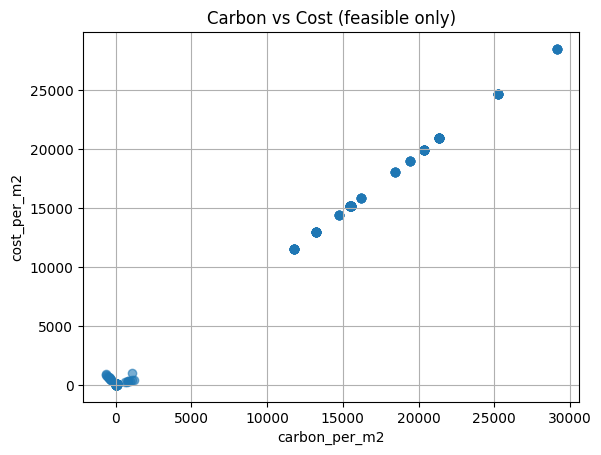

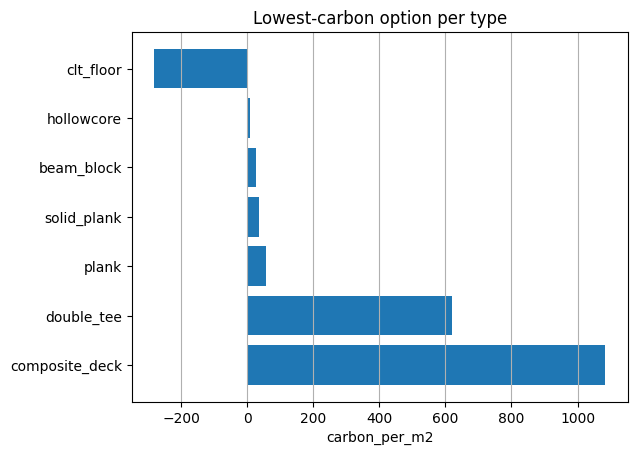

In [2]:
from IPython.display import display, clear_output
from ipywidgets import Text, Button, VBox, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from earlystruct.cli import evaluate

_last_click_ts = 0.0  # for debouncing extra callbacks

SHOW_COLS = [
    "type", "system_id", "system_name", "manufacturer", "category",
    "span_m", "depth_m", "carbon_per_m2", "cost_per_m2", "reason",
]

# ---------- core logic ----------

def best_by_type_only(df: pd.DataFrame, *, treat_zero_as_missing: bool = True) -> pd.DataFrame:
    """Return one lowest-carbon feasible row per type."""
    if "feasible" not in df.columns:
        raise ValueError("Column 'feasible' not found in results DataFrame.")

    feas = df[df["feasible"] == True].copy()

    feas["carbon_key"] = feas["carbon_per_m2"]
    if treat_zero_as_missing:
        feas.loc[
            feas["carbon_key"].isna() | (feas["carbon_key"] <= 0),
            "carbon_key"
        ] = np.inf
    else:
        feas["carbon_key"] = feas["carbon_key"].fillna(np.inf)

    feas["cost_key"] = feas["cost_per_m2"].fillna(np.inf)
    feas["depth_key"] = feas["depth_m"].fillna(np.inf)

    if "type" not in feas.columns:
        raise ValueError("Column 'type' not found in results DataFrame.")

    best = (
        feas.sort_values(["type", "carbon_key", "cost_key", "depth_key"])
            .groupby("type", as_index=False)
            .first()
    )

    cols = [c for c in SHOW_COLS if c in best.columns]
    return best[cols].sort_values("carbon_per_m2", na_position="last")


def render_summary(df: pd.DataFrame) -> None:
    """Print table + draw charts (no clearing here)."""
    n_all = len(df)
    n_feas = int((df["feasible"] == True).sum())
    print(f"Total candidates: {n_all}   |   feasible: {n_feas}")

    best = best_by_type_only(df)
    print("\nLowest-carbon option per type (feasible only):")
    if best.empty:
        print("  (none)")
    else:
        display(best.reset_index(drop=True))

    feas = df[
        (df["feasible"] == True)
        & df["carbon_per_m2"].notna()
        & df["cost_per_m2"].notna()
    ].copy()

    if feas.empty:
        print("\nNo feasible rows with both carbon and cost; skipping charts.")
        return

    # scatter – feasible only
    fig, ax = plt.subplots()
    ax.scatter(feas["carbon_per_m2"], feas["cost_per_m2"], alpha=0.6)
    ax.set_xlabel("carbon_per_m2")
    ax.set_ylabel("cost_per_m2")
    ax.set_title("Carbon vs Cost (feasible only)")
    ax.grid(True)

    # bar – lowest carbon per type
    if not best.empty:
        fig, ax = plt.subplots()
        ax.barh(best["type"], best["carbon_per_m2"])
        ax.set_xlabel("carbon_per_m2")
        ax.set_title("Lowest-carbon option per type")
        ax.invert_yaxis()
        ax.grid(axis="x")


def on_run(_):
    """Button callback: clear cell output, redraw UI, then show fresh results."""
    global _last_click_ts
    now = time.time()

    # debounce: ignore duplicate callbacks within 0.3s
    if now - _last_click_ts < 0.3:
        return
    _last_click_ts = now

    # Clear everything this cell has shown so far (old table + charts + UI)
    clear_output(wait=True)

    # Re-display the UI so the widgets stay visible
    display(ui)

    status.value = "<b>Running…</b>"
    try:
        cf = control_file.value.strip() or None
        df, ranked, pareto_df, _ = evaluate(
            data_dir.value,
            spans.value or None,
            None,
            cf,
        )

        render_summary(df)

        best_type = best_by_type_only(df)
        status.value = (
            f"<b>Done.</b> All: {len(df)} | "
            f"Feasible: {int((df['feasible']==True).sum()) } "
            f"Types shown: {len(best_type)}"
        )

    except Exception as e:
        status.value = f'<span style="color:red">Error: {e}</span>'


# ---------- widgets & layout ----------

data_dir = Text(
    value='/Users/benjaminsalop/Desktop/Oxford/Research/edca/csvs',
    description='Data dir:',
    layout={'width': '70%'},
)
control_file = Text(
    value='/Users/benjaminsalop/Desktop/Oxford/Research/edca/control_files/control_file.txt',
    description='Control:',
    layout={'width': '70%'},
)
spans = Text(
    value='6',
    description='Spans:',
)

run_btn = Button(description='Run Evaluation', button_style='primary')
status = HTML(value='')

run_btn.on_click(on_run)

ui = VBox([data_dir, control_file, spans, run_btn, status])

# show the UI once
display(ui)
